Sentiment Analysis on the fifa 2022 worldcup dataset, im not looking for no insights in here just applying VADERS model and roberta pre-trained model from Huggingface on this random dataset i've found on Kaggle.

In [1]:
# !pip install gdown
!pip install transformers
!gdown 1QHkAS4LuCgD23XaIl-DB0HwbdrXQDqHt # downloading the dataset from my google drive. 
# if you prefer to load the data yourself: https://www.kaggle.com/datasets/tirendazacademy/fifa-world-cup-2022-tweets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # its used to create progress bars for the loops
from nltk import download
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')
download(['punkt','vader_lexicon'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.5 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1QHkAS4LuCgD23XaIl-DB0HwbdrXQDqHt
To: /content/fifa_world_cup_2022_tweets.csv
100% 4.55M/4.55M [00:00<00:00, 168MB/s]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
df = pd.read_csv('fifa_world_cup_2022_tweets.csv') # Source: Kaggle.com
df.drop('Unnamed: 0',axis=1, inplace=True)
print('2022 Fifa worldcup tweets dataset with the shape of',df.shape)
df.sample(5)
# its already labeled so we can compare our results with the Sentiment column

2022 Fifa worldcup tweets dataset with the shape of (22524, 5)


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
3355,2022-11-20 17:00:17+00:00,17,Twitter for iPhone,Qatar’s keeper at Half Time #WorldCup2022 #QAT...,neutral
5786,2022-11-20 16:23:04+00:00,0,Twitter for iPhone,Block or Charge? #WorldCup2022,neutral
12068,2022-11-20 15:50:48+00:00,1,Twitter for iPhone,WC opening match as3 low profile international...,neutral
8487,2022-11-20 16:09:57+00:00,0,Twitter for Android,The excellent part of match fixing has commenc...,positive
19592,2022-11-20 09:50:30+00:00,11,Twitter for Android,"I love the World Cup. Always have done, since ...",positive


negative    5784
neutral     8251
positive    8489
Name: Sentiment, dtype: int64


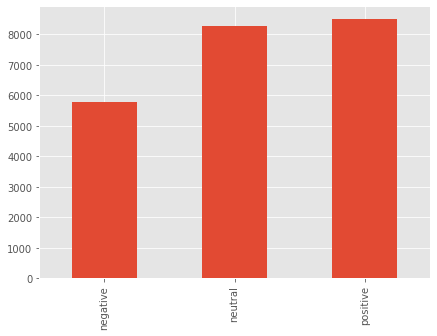

In [3]:
print(df['Sentiment'].value_counts().sort_index())
df['Sentiment'].value_counts().sort_index().plot(kind='bar',figsize=(7,5))
plt.show()

In [4]:
# tokens = df.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)

In [5]:
sia = SentimentIntensityAnalyzer()

In [6]:
res = []
for i, row in df.iterrows():
  text= row['Tweet']
  res.append(sia.polarity_scores(text))

In [7]:
sentclassify = []
for i in range(len(res)):
  if res[i]['compound'] >= 0.05 :
        sentclassify.append("positive")
 
  elif res[i]['compound'] <= - 0.05 :
        sentclassify.append("negative")
 
  else :
        sentclassify.append("neutral")

In [8]:
vader = pd.DataFrame(sentclassify)
df['vader'] = vader
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,vader
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,neutral


One of the cons of vaders is that it doesn't understand relations between the words, for instance we have sarcastic phrases.

now i am going to go with roberta, a pre-trained model which has been trained on 58m tweets.

In [10]:
robertahuggingface = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(robertahuggingface)
tokenizer = AutoTokenizer.from_pretrained(robertahuggingface)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [11]:
def polarity_scores_roberta(Input):
    encoded_text = tokenizer(Input, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [12]:
df2 = df.head(500) # using only 500 observations for the roberta model otherwise it'll take forever to finish.
res = []
for i, row in tqdm(df2.iterrows(), total=len(df2)): 
  text= row['Tweet']
  res.append(polarity_scores_roberta(text))

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
roberta = []
for i in range(len(res)):
  argmax = np.argmax(res[i])
  if argmax == 0:
    roberta.append('negative')
  elif argmax == 1:
    roberta.append('neutral')
  else:
    roberta.append('positive')
df2['roberta'] = roberta
df2.sample(10)

<ipython-input-13-8465ff0e5128>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['roberta'] = roberta


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,vader,roberta
436,2022-11-20 22:34:17+00:00,8,Twitter for iPhone,"The best thing you will see today, after the d...",positive,positive,positive
127,2022-11-20 23:19:17+00:00,1,Twitter for iPhone,If we can have a few more adverts from @SBS du...,positive,positive,positive
38,2022-11-20 23:46:30+00:00,0,Twitter Web App,"With your looks, you couldn't even get with a ...",negative,neutral,negative
426,2022-11-20 22:35:37+00:00,0,LaterMedia,Save yourself the price of a ticket and follow...,positive,positive,positive
27,2022-11-20 23:49:47+00:00,2,Twitter Web App,Well that was fun. When you never qualify on y...,positive,positive,positive
311,2022-11-20 22:49:36+00:00,2,Twitter for Android,Asking David Beckham if he regrets his £10m as...,negative,negative,negative
289,2022-11-20 22:53:13+00:00,0,Twitter for iPad,As an ardent @EnglandRugby and @ECB_cricket n...,neutral,positive,neutral
226,2022-11-20 23:04:23+00:00,0,Twitter Web App,World Cup 2022 ⚽⚽⚽⚽ has started. What smart wa...,neutral,positive,neutral
162,2022-11-20 23:14:38+00:00,1,Twitter for iPhone,We have joined the party with @Zocalo_Sactown ...,neutral,positive,neutral
144,2022-11-20 23:16:53+00:00,0,Twitter Web App,Stop American emigrant from going any damn whe...,negative,negative,negative


In [15]:
# im not sure if the sentiment column i
print('sentiment column\n',df2['Sentiment'].value_counts().sort_index(),'\n---')
print('vader model prediction\n',df2['vader'].value_counts().sort_index(),'\n---')
print('roberta model prediction\n',df2['roberta'].value_counts().sort_index())

sentiment column
 negative    126
neutral     201
positive    173
Name: Sentiment, dtype: int64 
---
vader model prediction
 negative    113
neutral     158
positive    229
Name: vader, dtype: int64 
---
roberta model prediction
 negative    127
neutral     219
positive    154
Name: roberta, dtype: int64
